## Обработка взаимодействий пользователей с товарами

В данном ноутбуке проводится предварительная обработка отзывов пользователей на продукты из категории *Grocery and Gourmet Food* (Amazon). Цель — подготовить чистый, сбалансированный и актуальный датасет взаимодействий, пригодный для построения рекомендательной системы.

На выходе получается таблица взаимодействий `amazon_interactions_filtered.csv`, очищенная и суженная до релевантных пользователей, товаров и временного периода.

Далее, при построении обучающей и тестовой выборки, взаимодействия будут разделены по времени, а не случайно.

In [1]:
# Импорт необходимых библиотек для анализа, визуализации и загрузки данных
import gzip
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

### Почему можно использовать отзывы как основу для рекомендательной модели

В нашем проекте мы используем Amazon Grocery Review Dataset, в котором представлены пользовательские отзывы на товары (в том числе оценка, дата и ID товара). Хотя в нём **не указаны покупки напрямую**, он остаётся валидным источником взаимодействий для построения рекомендательной системы.

---

#### Отзыв = подтверждённое взаимодействие

- Пользователь **оставил отзыв с оценкой (1–5)** — это сильный сигнал вовлечённости
- В большинстве случаев отзыв означает, что товар был:
  - куплен,
  - получен,
  - опробован,
  - и оценён

---

#### Отзывы ≈ proxy для implicit feedback

Хотя мы не видим сам факт покупки, **само наличие отзыва уже подтверждает "интерес"**.  
А это — основа implicit моделей, где взаимодействие — это:

- просмотр, клик, добавление в корзину
- **и особенно — покупка или отзыв**

В рекомендательных системах (в том числе на продакшене Amazon) **отзывы активно используются**, например:

- Neural Collaborative Filtering (He et al., 2017)
- SASRec, BERT4Rec
- RecSys-чемпионаты и исследования

---

#### Почему хватает самих отзывов

- Даже если пользователь не оставляет отзыв на каждый товар, **отзывов всё равно достаточно**, чтобы:
  - построить его профиль интересов
  - рассчитать эмбеддинги товаров
  - применить `Precision@K`, `MAP@K` для валидации

- **Фильтрация по активности** (например, ≥2 отзыва) позволяет работать только с теми пользователями, у кого есть достаточная история

---

Вывод: **отзывы — это валидный, широко используемый источник взаимодействий**, на основе которого можно обучить рекомендательную систему ранжирования и качественно её валидировать.


In [2]:
# Функция для чтения JSONL-структуры из gzip-файла 
# и преобразования в DataFrame
def load_amazon_inter(path, limit=None):
    data = []
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            data.append(json.loads(line))
            if limit and i + 1 >= limit:
                break
    return pd.DataFrame(data)

In [3]:
# Указываем путь к исходному файлу с отзывами
path = "data/Grocery_and_Gourmet_Food.json.gz"
df = load_amazon_inter(path)

## Описание данных в Grocery and Gourmet Food
`overall` — оценка товара по шкале от 1 до 5 (звёзд);  
`reviewTime` — дата отзыва в текстовом формате (например, "06 4, 2013");  
`reviewerID` — уникальный идентификатор пользователя;  
`asin` — уникальный идентификатор товара (Amazon Standard Identification Number);  
`reviewerName` — имя пользователя (может отсутствовать);  
`reviewText` — основной текст отзыва;  
`summary` — краткое резюме (заголовок) отзыва;  
`unixReviewTime` — временная метка отзыва в формате UNIX (кол-во секунд с 01.01.1970);  
`vote` — количество голосов за полезность отзыва (часто отсутствует);  
`image` — список URL-адресов изображений, прикреплённых к отзыву (если есть);  
`style` — словарь с дополнительными характеристиками товара (например, цвет, размер — часто пустой).

Для моделирования рекомендательной системы наиболее важны:
- `reviewerID`, `asin`, `unixReviewTime`, `overall`

Остальные могут быть удалены или сохранены при необходимости.

In [4]:
# Получаем информацию о количестве строк, типах столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074160 entries, 0 to 5074159
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   reviewerName    object 
 6   reviewText      object 
 7   summary         object 
 8   unixReviewTime  int64  
 9   vote            object 
 10  image           object 
 11  style           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 430.7+ MB


In [5]:
df.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5.0,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly l...,Love it,1370304000,NaN,NaN,NaN
1,4.0,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to...,Nice but small,1400803200,NaN,NaN,NaN


In [6]:
# Оставим только необходимые нам для модели и анализа столбцы
df = df[["reviewerID", "asin", "unixReviewTime", "overall"]]

In [7]:
# Приводим имена колонок к единообразному виду
df.rename(columns={
    "reviewerID": "user_id",
    "asin": "item_id",
    "unixReviewTime": "timestamp",
    "overall": "rating"
}, inplace=True)

In [8]:
# Проверим на пропуски
print(df[["user_id", "item_id", "timestamp", "rating"]].isna().sum())

user_id      0
item_id      0
timestamp    0
rating       0
dtype: int64


In [9]:
# Проверяем, есть ли пустые строки (не NaN) в идентификаторах
for col in ["user_id", "item_id"]:
    n_empty = (df[col].str.strip() == "").sum()
    print(f"{col}: пустых строк — {n_empty}")

user_id: пустых строк — 0
item_id: пустых строк — 0


In [10]:
# Выводим сводную статистику по количеству отзывов на одного пользователя и на товар
print(f"Уникальных пользователей: {df['user_id'].nunique():,}")
print(f"Уникальных товаров: {df['item_id'].nunique():,}")

# Распределение по количеству отзывов на пользователя
user_counts = df["user_id"].value_counts()
print("\nРаспределение отзывов на пользователя:")
print(user_counts.describe())

# Распределение по количеству отзывов на товар
item_counts = df["item_id"].value_counts()
print("\nРаспределение отзывов на товар:")
print(item_counts.describe())


Уникальных пользователей: 2,695,974
Уникальных товаров: 283,507

Распределение отзывов на пользователя:
count    2.695974e+06
mean     1.882125e+00
std      3.187802e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.103000e+03
Name: count, dtype: float64

Распределение отзывов на товар:
count    283507.00000
mean         17.89783
std         107.50136
min           1.00000
25%           1.00000
50%           3.00000
75%           9.00000
max       11526.00000
Name: count, dtype: float64


**EDA: Анализ взаимодействий пользователей и товаров**

После предобработки и очистки ключевых полей (`user_id`, `item_id`, `timestamp`, `rating`) были получены следующие обобщающие характеристики:

**Пользователи (`user_id`)**
- Уникальных пользователей: **2,695,974**
- Среднее количество отзывов на пользователя: **~1.88**
- Медиана: **1**
- 75% пользователей оставили **не более 2 отзывов**
- Максимум: **1,103 отзывов** от одного пользователя

**Вывод:** большинство пользователей — однократные, модель не сможет на них обучиться или делать рекомендации. Необходима фильтрация.

**Товары (`item_id`)**
- Уникальных товаров: **283,507**
- Среднее количество отзывов на товар: **~17.9**
- Медиана: **3**
- 75% товаров имеют **не более 9 отзывов**
- Максимум: **11,526 отзывов** у одного товара

**Вывод:** наблюдается длинный хвост товаров с малым числом взаимодействий. Необходимо отфильтровать самые "холодные" товары для повышения устойчивости модели.


In [11]:
# Считаем количество взаимодействий по пользователям и товарам
user_counts = df["user_id"].value_counts()
item_counts = df["item_id"].value_counts()

### Фильтрация по активности пользователей и товаров

Удаляем "холодные" товары и пассивных пользователей:
- Оставляем только пользователей с ≥2 отзывами
- И товары с ≥5 отзывами
Это помогает стабилизировать обучение модели и исключает шумовые взаимодействия.


In [12]:
# Оставляем пользователей с ≥2 отзывами и товары с ≥5 отзывами
active_users = user_counts[user_counts >= 2].index
popular_items = item_counts[item_counts >= 5].index

In [13]:
# Фильтруем
df_filtered = df[df["user_id"].isin(active_users) & df["item_id"].isin(popular_items)]

In [14]:
print(f"Осталось строк: {len(df_filtered):,}")
print(f"Уникальных пользователей: {df_filtered['user_id'].nunique():,}")
print(f"Уникальных товаров: {df_filtered['item_id'].nunique():,}")

Осталось строк: 3,044,960
Уникальных пользователей: 857,529
Уникальных товаров: 106,591


In [15]:
# Сохраняем отфильтрованные взаимодействия для последующего использования
df_filtered.to_csv("data/amazon_interactions_filtered.csv", index=False)

In [16]:
# Выводим минимальную и максимальную дату по unix timestamp
ts_min = df_filtered["timestamp"].min()
ts_max = df_filtered["timestamp"].max()

In [17]:
print("Минимальная дата:", datetime.datetime.utcfromtimestamp(ts_min).date())
print("Максимальная дата:", datetime.datetime.utcfromtimestamp(ts_max).date())

Минимальная дата: 2000-08-09
Максимальная дата: 2018-10-05


C:\Users\Администратор\AppData\Local\Temp\ipykernel_8388\1005897093.py:1: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print("Минимальная дата:", datetime.datetime.utcfromtimestamp(ts_min).date())
C:\Users\Администратор\AppData\Local\Temp\ipykernel_8388\1005897093.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print("Максимальная дата:", datetime.datetime.utcfromtimestamp(ts_max).date())


### Временной анализ

Построим распределение количества отзывов по годам, чтобы определить наиболее насыщенный временной отрезок.


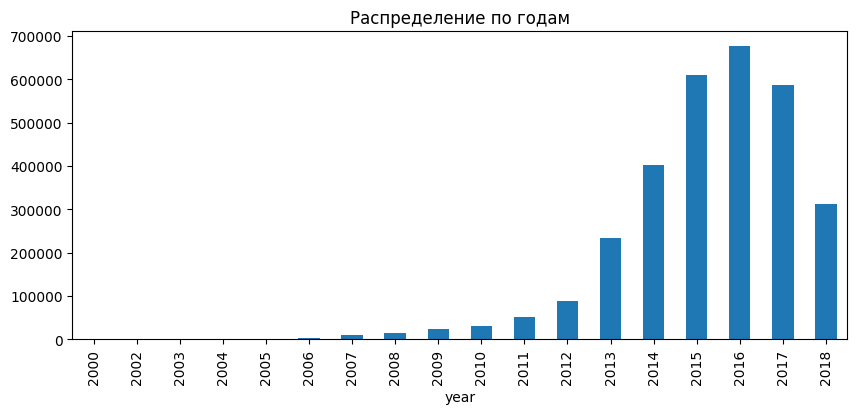

In [18]:
# Визуализируем, как распределены взаимодействия по годам
df = df_filtered.copy()
df["year"] = pd.to_datetime(df["timestamp"], unit="s").dt.year
df["year"].value_counts().sort_index().plot(kind="bar", figsize=(10, 4), title="Распределение по годам")
plt.show()

### Результаты предобработки и EDA взаимодействий

- Исходный датасет Amazon Grocery Reviews (`Grocery_and_Gourmet_Food_5.json.gz`) содержал ~5 млн строк и охватывал период с 2000 по 2018 год.
- После фильтрации по активности (`user_id ≥ 2`, `item_id ≥ 5`) осталось:
  - **3,044,960** строк
  - **857,529** пользователей
  - **106,591** товаров

Это ядро содержит **достаточно плотные, чистые и современные** взаимодействия.

---

### Выбор временного диапазона

Анализ распределения отзывов по годам показал, что наиболее насыщенными по количеству взаимодействий являются **2015–2017 годы**, а 2018 год может быть использован как **временной hold-out для тестирования**.

Дальнейшее формирование обучающей и тестовой выборки будет осуществляться **по временной оси**, без случайного перемешивания, и реализовано в следующем ноутбуке.
